### import necessary packages:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import datetime


# Set pyplot font style to Computer Modern and enable LaTeX code...

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})

In [2]:
df = pd.read_excel('flexpowerdata.xlsx',sheet_name='DE_Wind_PV_Prices')

# truncate data frame to only include 2021 entries. df_2021 has 35040 rows, which should be correct. (365 * 24 * 4)
df_2021 = df[df['time']<'2022-01-01'] 

### Task 1:

#### Calculate total Wind and PV generation in 2021 according to Day-Ahead and Intraday Forecast respectively.

In [5]:
wind_da_total = np.sum(df_2021['Wind Day Ahead Forecast [in MW]'].values)/4/1000000 
wind_id_total = np.sum(df_2021['Wind Intraday Forecast [in MW]'].values)/4/1000000
pv_da_total = np.sum(df_2021['PV Day Ahead Forecast [in MW]'].values)/4/1000000
pv_id_total = np.sum(df_2021['PV Intraday Forecast [in MW]'].values)/4/1000000

# divide by 10**6 to get value in TWh.

In [6]:
print('Day-Ahead Wind Total: ', np.round(wind_da_total,decimals=2),'TWh')
print('Intraday Wind Total: ', np.round(wind_id_total,decimals=2),'TWh')
print('Day-Ahead PV Total: ', np.round(pv_da_total,decimals=2),'TWh')
print('Intraday PV Total: ', np.round(pv_id_total,decimals=2),'TWh')

Day-Ahead Wind Total:  115.4 TWh
Intraday Wind Total:  113.48 TWh
Day-Ahead PV Total:  46.09 TWh
Intraday PV Total:  46.69 TWh


### Task 2:
#### Show daily average Wind/PV production in 2021 according to Day-Ahead and Intraday forecasts respectively.

In [7]:
da_wind = []
id_wind = []
da_pv = []
id_pv = []
dates = []

date_a = datetime.datetime(2021, 1, 1, 0, 0, 0)

for _ in range(365):

    # i use [date_a, date_b] as the interval to select all 96 entries of each individual day in the following lines.
    date_b = date_a + datetime.timedelta(days=1) 

    # append the mean of all 96 forecasts of given day
    da_wind.append(np.mean(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Wind Day Ahead Forecast [in MW]'].values)) 
    id_wind.append(np.mean(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Wind Intraday Forecast [in MW]'].values))
    da_pv.append(np.mean(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['PV Day Ahead Forecast [in MW]'].values))
    id_pv.append(np.mean(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['PV Intraday Forecast [in MW]'].values))

    dates.append(date_a)

    # shift date_a one day forward to iterate.
    date_a = date_b 


''

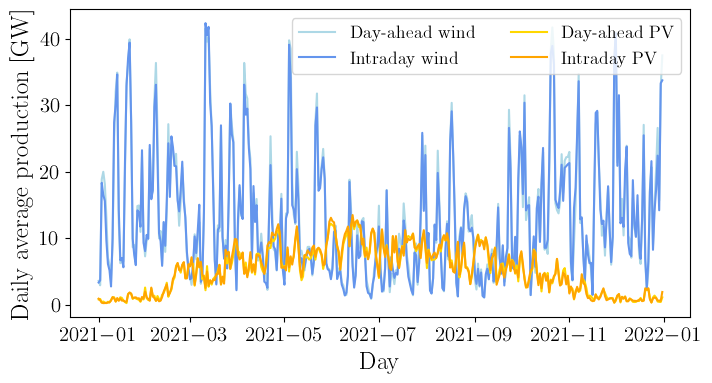

In [8]:
plt.figure(figsize=(8,4))

plt.plot(dates,da_wind,color='lightblue',label='Day-ahead wind')
plt.plot(dates,id_wind,color='cornflowerblue',label='Intraday wind')

plt.plot(dates,da_pv,color='gold',label='Day-ahead PV')
plt.plot(dates,id_pv,color='orange',label='Intraday PV')

plt.yticks(ticks=[0,10000,20000,30000,40000],labels=[0,10,20,30,40],fontsize=15)
plt.xticks(fontsize=15)

plt.ylabel('Daily average production [GW]',fontsize=18)
plt.xlabel('Day',fontsize=18)

plt.legend(fontsize=13, ncols=2)
;

### Task 3:
#### Calculate the average value of Wind and PV Power according to the Day-ahead forecasts and Day-Ahead prices.

In [10]:
hour_prod_wind = []
hour_prod_pv = []
hour_price = []
dates = []

date_a = datetime.datetime(2021, 1, 1, 0, 0, 0)

for _ in range(365*24):

    date_b = date_a + datetime.timedelta(hours=1)

    # collect hourly average wind/pv production for each hour in 2021
    # I use np.sum(...)/4 here instead of np.mean(...), because np.mean caused some weird issues here, so this is a quick workaround.
    hour_prod_wind.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Wind Day Ahead Forecast [in MW]'].values/4))    
    hour_prod_pv.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['PV Day Ahead Forecast [in MW]'].values/4))

    hour_price.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Day Ahead Price hourly [in EUR/MWh]'].values/4))

    dates.append(date_a)

    date_a = date_b


In [13]:
avg_price = np.mean(hour_price)

# calculate average prices weighted by wind/pv production at each hour
avg_price_wind = np.sum((np.asarray(hour_prod_wind) * hour_price) / np.sum(hour_prod_wind))
avg_price_pv = np.sum((np.asarray(hour_prod_pv) * hour_price) / np.sum(hour_prod_pv))


print('Average Day-Ahead price in 2021:', np.round(avg_price,decimals=2), 'EUR/MWh')
print('Average Day-Ahead price for Wind Power in 2021:', np.round(avg_price_wind,decimals=2), 'EUR/MWh')
print('Average Day-Ahead price for PV Power 2021:', np.round(avg_price_pv,decimals=2), 'EUR/MWh')

Average Day-Ahead price in 2021: 96.85 EUR/MWh
Average Day-Ahead price for Wind Power in 2021: 81.41 EUR/MWh
Average Day-Ahead price for PV Power 2021: 76.89 EUR/MWh


It is known that VREs have a lower market value compared to non-variable sources. 

Simple example: If the sun shines, it typically shines for most solar plants in Germany (or even Europe), which causes high solar power production. PV power has very low marginal cost and according to merit order principle, this pushes the total market clearing price, since more expensive generation sources are turned off.

See "The market value of variable renewables: The effect of solar wind power variability on their relative price" by Lion Hirth, which is a well-known paper on that topic.

### Task 4:
#### Calculate the average Day-Ahead prices on the days with highest and lowest Wind+PV production.

In [14]:
day_prod_res = [] 
day_price = [] 
dates = []

date_a = datetime.datetime(2021, 1, 1, 0, 0, 0)

for _ in range(365):

    date_b = date_a + datetime.timedelta(days=1)

    # daily production of Wind+PV
    day_prod_res.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Wind Day Ahead Forecast [in MW]'].values/96) + np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['PV Day Ahead Forecast [in MW]'].values/96))
    
    # daily average price
    day_price.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Day Ahead Price hourly [in EUR/MWh]'].values/96))

    dates.append(date_a)

    date_a = date_b

In [15]:
print('Price at day with highest RES generation:',np.round(day_price[np.argmax(day_prod_res)],decimals=2),'EUR/MWh') # print daily average price of day with highest RE production in 2021.
print('Price at day with lowest RES generation:',np.round(day_price[np.argmin(day_prod_res)],decimals=2),'EUR/MWh') # print daily average price of day with lowest RE production in 2021.

Price at day with highest RES generation: 22.29 EUR/MWh
Price at day with lowest RES generation: 237.46 EUR/MWh


In order to satisfy demand, generation sources are broadly determined by the merit order principle. Power sources with lowest marginal cost come first. Wind and PV are the cheapest sources (almost 0 generation cost). For example at days with high Wind and PV generation, ideally on a Saturday or Sunday, Wind and PV alone might be enough to satisfy demand. On the other hand, on days with high demand (weekdays) and very little RES power generation, power generation also comes from up the curve, which are generation types with very high production costs (gas and even oil).

### Task 5:
#### Calculate average hourly Day-Ahead price on weekdays vs. weekends.

In [16]:
prices_weekday = []
prices_weekend = []
for i in range(len(df_2021)):

    # use timestamp.weekday() to check if timestamp is on weekday or not.
    if df_2021['time'][i].weekday() <= 4:   
        prices_weekday.append(df_2021['Day Ahead Price hourly [in EUR/MWh]'][i])
    else:
        prices_weekend.append(df_2021['Day Ahead Price hourly [in EUR/MWh]'][i])


In [17]:
print('Average Day-Ahead price during weekends in 2021:', np.round(np.mean(prices_weekend),decimals=2),'EUR/MWh')
print('Average Day-Ahead price during weekdays in 2021:', np.round(np.mean(prices_weekday),decimals=2),'EUR/MWh')

Average Day-Ahead price during weekends in 2021: 77.98 EUR/MWh
Average Day-Ahead price during weekdays in 2021: 104.37 EUR/MWh


This is due to overall lower demand on the saturdays and sundays (i guess mainly because many industrial facilities are closed). Therefore due to the merit order principle, demand is typically satisfied lower down the curve.

### Task 6:
#### Arbitrage with a 1MWh battery storage and one charge-discharge cycle per day.

In [29]:
hourly_avg_price = []

# construct array with average prices of each hour of the day in 2021
for t in range(24):
    hourly_avg_price.append(np.mean(df_2021[df_2021['hour'] == t]['Day Ahead Price hourly [in EUR/MWh]'].values))

Text(0.5, 0, 'hour of day')

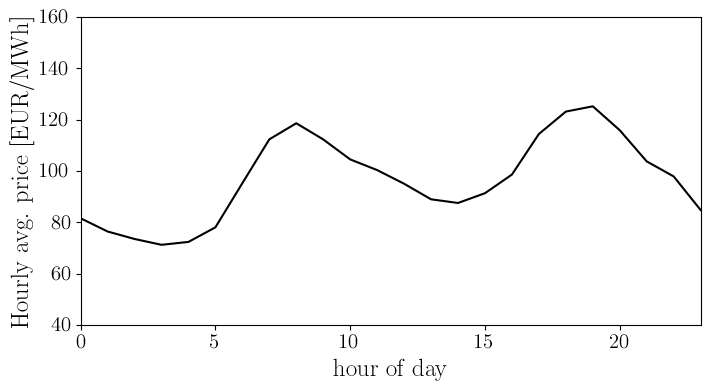

In [39]:
plt.figure(figsize=(8,4))

plt.plot(hourly_avg_price,color='black')

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(40,160)
plt.xlim(0,23)

plt.ylabel('Hourly avg. price [EUR/MWh]',fontsize=18)
plt.xlabel('hour of day',fontsize=18)



In [41]:
print('max average price at hour:', np.argmax(hourly_avg_price))
print('min average price at hour:', np.argmin(hourly_avg_price))

max average price at hour: 19
min average price at hour: 3


therefore our best guess is to load our battery every day at 3h and discharge at 19h.

In [61]:
profit_3to19 = (hourly_avg_price[19] - hourly_avg_price[3]) * 365

In [66]:
print('Profit for the above strategy in 2021 is:', np.round(profit_3to19,decimals=2), 'EUR')

Profit for the above strategy in 2021 is: 19695.44 EUR


Below, i calculate the possible profit with perfect foresight, which means that you always buy in the cheapest hour and sell in the most expensive hour of each day.

In [64]:
day_price_low = []
day_price_high = []
dates = []

date_a = datetime.datetime(2021, 1, 1, 0, 0, 0)

for _ in range(365):

    date_b = date_a + datetime.timedelta(days=1)

    day_price_low.append(np.min(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Day Ahead Price hourly [in EUR/MWh]'].values))
    day_price_high.append(np.max(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Day Ahead Price hourly [in EUR/MWh]'].values))
  
    dates.append(date_a)

    date_a = date_b

In [65]:
print('Perfect foresight yields:', np.round(np.sum(np.asarray(day_price_high)-day_price_low),decimals=2), 'EUR')

Perfect foresight yields: 29311.6 EUR for total 2021.


Note that this is a bit simplified. For example it is possible here, that the daily high occurs before the daily low. However, this is just to show that there is plenty room for improvement compared to the 3h to 19h strategy.

### Task 7:
#### Arbitraging strategy between Day-Ahead and Intraday.

The idea here is, that, while the day-ahead market has a singular market clearing price, the intraday markets follow a pay-as-bid principle, similar to for example the stock market. On the intraday markets we almost always see highs that are higher than the corresponding day-ahead price and lows that are lower. The given dataframe only includes an average intraday hourly price (i assume weighted average?), so we have to find something profitable with that time series.

In [85]:
print('Hourly avg. day-ahead price:', np.mean(df_2021['Day Ahead Price hourly [in EUR/MWh]'].values),'EUR/MWh')
print('Hourly avg. Intraday price:', np.mean(df_2021['Intraday Price Hourly  [in EUR/MWh]'].values),'EUR/MWh')

Hourly avg. day-ahead price: 96.84991780821919 EUR/MWh
Hourly avg. Intraday price: 97.98849528120412 EUR/MWh


We see above, that there seems to be a small systematic premium of around 1 EUR/MWh between Intraday and Day-Ahead market. This is not enough to be interesting though. (Actually, i think it is. In general i would like to know more about why the market is so unefficient)

One idea that i want to analyze here is if high Wind+PV generation causes a systematically higher Intraday price compared to the Day-Ahead price.


In [149]:
#
intraday_prices = df_2021['Intraday Price Hourly  [in EUR/MWh]'].values
dayahead_prices = df_2021['Day Ahead Price hourly [in EUR/MWh]'].values


# difference of intraday and dayahead for each quarter of 2021
diff_id_da = df_2021['Intraday Price Hourly  [in EUR/MWh]'].values - df_2021['Day Ahead Price hourly [in EUR/MWh]'].values

# wind generation, pv generation and wind+pv generation (per forecast) for each quarter in 2021.
winds = df_2021['Wind Intraday Forecast [in MW]'].values
pvs = df_2021['PV Intraday Forecast [in MW]'].values
res = winds+pvs

First take a look at the scatter plot. It does not look too promising, but lets dig a bit deeper. 

Text(0, 0.5, 'Difference ID-DA price [EUR/MWh]')

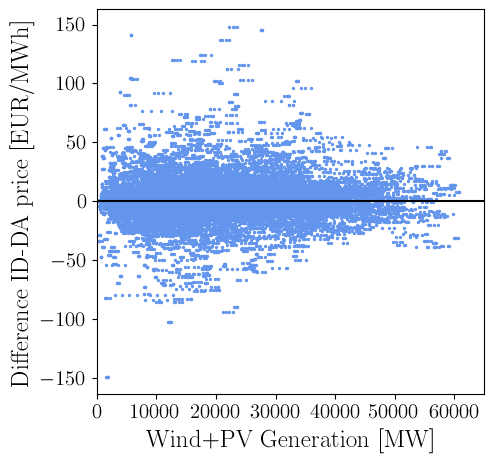

In [141]:
plt.figure(figsize=(5,5))
plt.scatter(res,diff_id_da,s=2,color='cornflowerblue')
plt.hlines(0,0,65000,color='black')
plt.xlim(0,65000)

plt.xticks(fontsize=15)
plt.xlabel('Wind+PV Generation [MW]',fontsize=18)

plt.yticks(fontsize=15)
plt.ylabel('Difference ID-DA price [EUR/MWh]',fontsize=18)

Let's check for all quarters where the combined Wind+PV generation is above a certain threshold.

In [146]:
# These are the threshold values we want to try out
x_grid = np.arange(0,52500,2500)

# These are the corresponding Intraday premiums
premiums = []

for thresh in x_grid:

    filtered_diffs = []
    for t in range(len(res)):
        if res[t] > thresh:
            filtered_diffs.append(diff_id_da[t])

    premiums.append(np.mean(filtered_diffs))

(0.0, 3.0)

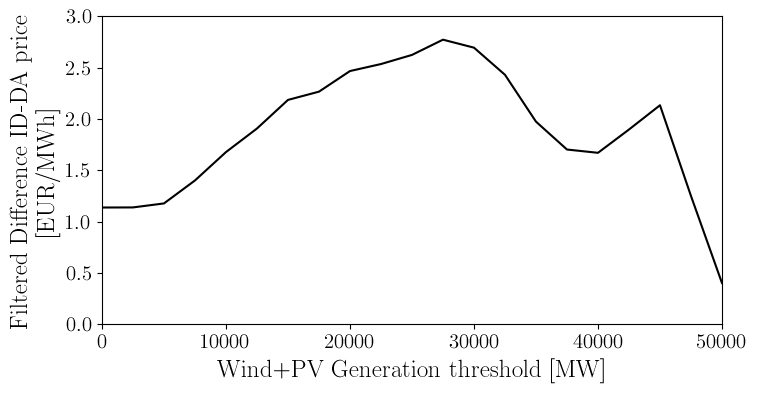

In [148]:
plt.figure(figsize=(8,4))

plt.plot(x_grid,premiums,color='black')

plt.xticks(fontsize=15)
plt.xlabel('Wind+PV Generation threshold [MW]',fontsize=18)

plt.yticks(fontsize=15)
plt.ylabel('Filtered Difference ID-DA price \n [EUR/MWh]',fontsize=18)

plt.xlim(0,50000)
plt.ylim(0,3)

We definately see something here. If we filter for quarters where the combined wind+pv generation is higher than 27500 MW, then the Average Difference between Intraday and Dayahead price is around 2.7 EUR/MWH. It is important to note that this might already be an 'overfitted' strategy. But let's try out what it yields anyways.

In [171]:
# 25 MW positions per quarter. So if we expect the condition fulfilled in each quarter of an hour then we take a 100MW trade as desired.
size = 25

# in this array we store the costs for each buy from the dayahead
buys = [] 

# in this array we store the profit from each sale on the intraday
sells = []

for t in range(len(res)):

    if res[t] > 27500:
        buys.append(dayahead_prices[t]*size)
        sells.append(intraday_prices[t]*size)


In [172]:
print(len(buys))

7601


there are 7601 quarters where the strategy criterium is fulfilled. (thats around 21% of all quarters so we take trades veeery frequently here...)

In [176]:
print('Total profit in 2021:', np.round(np.sum(np.asarray(sells)-buys),decimals=2), 'EUR')

Total profit in 2021: 527027.98 EUR


According to the simulation this strategy would have made 527000 Euros in 2021.

We do not require any physical assets since we always buy and sell the same amount of power in each quarter.

I have my doubts that this strategy is realistic. First and foremost because I would expect the market to be efficient enough to not allow for such a simple strategy. So perhaps there is a reason why this does not work in practice. 

The first idea that comes to mind is that 100MW positions are already quite large and especially on the Intraday market we should expect to move the market with our offers. 

Second, there might be some restrictions to how arbitraging between different markets can or can not be done.

Finally, market participants might refrain from such a strategy because, while it might be profitable statistically, the possible penalty for outlier events might be too high. Under very unlucky circumstances it might not be possible to completely sell our electricity on the intraday market, which would leave us out of balance virtually. This would results in high fees for 'Regelenergie'. 